## Step 1 -- import necessary libraries

In [90]:
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpp

import dask.dataframe as dd

import os # os.path
import datetime

%matplotlib notebook
from matplotlib import pyplot as plt
from numpy import array
from tensorflow.keras.activations import relu, softsign
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

%load_ext tensorboard

import foresight.backtesting
import foresight.data_functions as fx_df
import foresight.model
import foresight.util as fxu

importlib.reload(fx_df)
importlib.reload(fxu)
importlib.reload(foresight.model)
importlib.reload(foresight.backtesting)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 2.1 Specify the path of the source data

In [2]:
# src = '/var/local/foresight/timeseries/EURGBP-2016-01.pp1.xz'
src = "/var/local/foresight/timeseries/EURGBP-2017-1-6.csv"

### 2.1.1 Setup model parameters

In [120]:
scaler_type = "MinMaxScaler"  # [MinMaxScaler, None]
sample_time = "5T"  # T=minutes
seq_len = 12  # 1 hours
n_vars = 1
num_outs = 1  # number of future outputs to forecast
Transform = "LogDiff"  # [Diff, LogDiff, None]
model_name = '0005a_8-240_LSTM_5minData_1h_mse_mae'
models_base_path = '/var/local/foresight/models/Keras_Models/'
model_path = models_base_path + model_name

model_dropoff = 0.25
model_LSTM_units = 240

### 2.1.2 Setup training parameters

In [126]:
training_batch_size = 128
training_epochs_1 = 500
training_epochs_2 = 5000
training_loss_1 = 'mse' # ['mae', 'mse', 'mape']
training_optimizer_1 = 'nadam' # ['adam', 'nadam', 'adamax', ...] (see tf docs)
training_loss_2 = 'mae' # ['mae', 'mse', 'mape']
training_optimizer_2 = 'nadam' # ['adam', 'nadam', 'adamax', ...] (see tf docs)

# 3 Prepare Data

## 3.1 Import the data

1. Load the data into a dataframe
2. Specify the column names
3. Convert the date field into the correct datetime64 object

In [110]:
data_raw = fx_df.GetTickdataDataframe(src, date_format_string='%m/%d/%Y %H:%M:%S.%f')

## 3.2 Clean up the data

In [111]:
if not (fxu.VarExists(sample_time)):
    raise RuntimeError("'sample_time' must be defined")

data = fx_df.clean_data(
    data_raw,
    remove_duplicates=True,
    sample_frequency=sample_time,
    sample_type="nearest",
    remove_weekends=True,
)

## 3.3 Create transformer object

In [112]:
data_txr = fx_df.Data_Transformer(Transform, 2, scaler_type)

## 3.4 Extract data as an np.ndarray

In [37]:
data_arr = data["bid"].to_numpy()

# 4 Prepare Keras model

In [128]:
def BuildModel(training_loss , training_optimizer):
    if not (fxu.VarExists(seq_len)):
        raise RuntimeError("'seq_len' must be defined")

    if not (fxu.VarExists(n_vars)):
        raise RuntimeError("'n_vars' must be defined")
    
    # TODO: fix this somehow
    output_columns = [0]

    Activation_Function = "tanh"  # ['tanh', 'softsign', 'relu', 'elu', 'LeakyReLU']

    _metrics = [tf.keras.metrics.MeanAbsoluteError(name='mae'),
                tf.keras.metrics.MeanAbsolutePercentageError(name='mape'), 
                tf.keras.metrics.MeanSquaredError(name='mse'), 
#                tf.keras.metrics.RootMeanSquaredError(name='rmse'), 
#                tf.keras.metrics.LogCoshError(name='logcosh'), 
#                tf.keras.metrics.MeanSquaredLogarithmicError(name='msle')
               ]
    
    LSTM_model = Sequential()

    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, input_shape=(seq_len, n_vars), dropout=0))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=model_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=False, dropout=model_dropoff))
    if model_dropoff:
        LSTM_model.add(Dropout(model_dropoff))
    LSTM_model.add(Dense(len(output_columns)))
    # model.compile(loss= 'mae' , optimizer= 'nadam' )
    LSTM_model.compile(loss= training_loss , optimizer= training_optimizer, metrics = _metrics ) # 'adam'
    # model.build()
    print(LSTM_model.summary())
    
    return LSTM_model

# 5 Create foresight.Model object

In [115]:
def Create_FX_Model(training_loss, training_optimizer):
    fx_model = foresight.model.Model(
        model=BuildModel(training_loss , training_optimizer),
        data=data_arr,
        data_freq=pd.Timedelta(sample_time),
        seq_len=seq_len,
        scaler=None,
        forecast_horizon=1,
        data_transform=data_txr,
    #    stationary_transform=Transform,
        max_training_data_factor=2.0,
    )
    return fx_model

# 6 Fit timeseries Model

## 6.1 Setup callbacks

Callbacks are used here for 

- saving checkpoint info to disk to allow resuming the training of a model if it becomes interrupted
- saving tensorboard log information for visualization

### 6.1.1 Parameters

In [121]:
# Checkpoint parameters
checkpoint_file = model_path + '/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_file)
cp_freq_in_epochs = 10

# Tensorboard Parameters
tb_path = model_path + '/logs'
logdir = os.path.join(tb_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### 6.1.2 Create Checkpoint Callback

In [122]:
cp_approx_batches_per_epoch = (data_arr.shape[0] - seq_len)/training_batch_size
cp_save_freq = int(cp_approx_batches_per_epoch * cp_freq_in_epochs)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_file,
    save_weights_only=True,
    save_freq=cp_save_freq,
)

### 6.1.3 Create Tensorboard Callback

In [123]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=10)

## 6.2 Setup model directory and load checkpoint data, if available

In [124]:
def Try_Load_Checkpoint_Data(model):
    if not os.path.exists(checkpoint_dir):
        from pathlib import Path
        Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

    if os.path.isfile(checkpoint_file + '.index'):
        fx_model.Load_Weights(checkpoint_file)
        print('Loaded saved weights from checkpoint file')
    else:
        fx_model.Save_Weights(checkpoint_file)
        print('Initialized new checkpoint file')


## 6.3 Fit the model

## 6.3.1 Start tensorboard

In [ ]:
#%tensorboard --logdir var/local/foresight/models/Keras_Models/0001_6-LSTM_5minData_3h/logs
%tensorboard --logdir $tb_path --bind_all
#from tensorboard import notebook
#notebook.list()
#notebook.display(port=6006)

### First round of fitting - using MSE as loss function

In [ ]:
fx_model = Create_FX_Model(training_loss_1, training_optimizer_1)
Try_Load_Checkpoint_Data(fx_model)

_ = fx_model.Fit(
    batch_size=training_batch_size,
    epochs=training_epochs_1,
    train_frac=5 / 5,
    valid_frac=0 / 3,
    verbose=1,
    validate_model=False,
    print_test_stat=False,
    callbacks=[cp_callback, tb_callback],
)

### 2nd Stage of fitting - using MAE as loss function

In [ ]:
fx_model = Create_FX_Model(training_loss_2, training_optimizer_2)
Try_Load_Checkpoint_Data(fx_model)

_ = fx_model.Fit(
    batch_size=training_batch_size,
    epochs=training_epochs_2,
    train_frac=5 / 5,
    valid_frac=0 / 3,
    verbose=1,
    validate_model=False,
    print_test_stat=False,
    callbacks=[cp_callback, tb_callback],
)

In [ ]:
#fx_model._model.save(models_path + model_name)

# 6 Backtest the model

In [136]:
importlib.reload(foresight.backtesting)
importlib.reload(foresight.model)
importlib.reload(fx_df)
import foresight.tradingRules
import copy

importlib.reload(foresight.tradingRules)

print(type(fx_model))
_trading_rules = foresight.tradingRules.BasicTradingRules(
    trade_size=1_000, stop_loss=0.00015, take_profit=0.00025, min_change=0.00010
)
bt_model = foresight.model.Model(
    model=BuildModel(training_loss , training_optimizer),
    data=data_arr,
    data_freq=pd.Timedelta(sample_time),
    seq_len=seq_len,
    scaler=None,
    forecast_horizon=1,
    data_transform=data_txr,
#    stationary_transform=Transform,
    max_training_data_factor=2.0,
)

bt_model.Set_Weights(fx_model.Get_Weights())

backtester = foresight.backtesting.Backtester(
    model=fx_model, retraining_freq=pd.Timedelta("1W"), trading_rules=_trading_rules, initial_money=1_000,
)

<class 'foresight.model.Model'>
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 12, 240)           232320    
_________________________________________________________________
lstm_89 (LSTM)               (None, 12, 240)           461760    
_________________________________________________________________
lstm_90 (LSTM)               (None, 12, 240)           461760    
_________________________________________________________________
lstm_91 (LSTM)               (None, 12, 240)           461760    
_________________________________________________________________
lstm_92 (LSTM)               (None, 12, 240)           461760    
_________________________________________________________________
lstm_93 (LSTM)               (None, 12, 240)           461760    
_________________________________________________________________
lstm_94 (LSTM)       

In [132]:
bt_src = "/var/local/foresight/timeseries/EURGBP-2017-7-13.csv"
forecast_data = fx_df.GetTickdataDataframe(bt_src, date_format_string='%m/%d/%Y %H:%M:%S.%f')

In [137]:
backtester.Reset_Model()
bids, bid_hats = backtester.Backtest(
    forecast_data,
    initial_retraining=0,
    trading_rules = _trading_rules,
    retrain_batch_size=training_batch_size,
    retrain_epochs=1,
    retrain_verbose=True,
)

Retraining every 2016 points
Main backtesting loop - from indices:  0  to  2015
y_hat.shape (2015,)
Index: 0 current_bid: 0.85062 next_bid: 0.85065 forecast bid: 0.8502046582031251
Index: 1 current_bid: 0.85065 next_bid: 0.85075 forecast bid: 0.8502346435546875
Index: 2 current_bid: 0.85075 next_bid: 0.8507899999999999 forecast bid: 0.85075
Index: 3 current_bid: 0.8507899999999999 next_bid: 0.85085 forecast bid: 0.8507899999999999
Index: 4 current_bid: 0.85085 next_bid: 0.85083 forecast bid: 0.85085
Index: 5 current_bid: 0.85083 next_bid: 0.85085 forecast bid: 0.85083
Index: 6 current_bid: 0.85085 next_bid: 0.85062 forecast bid: 0.85085
Index: 7 current_bid: 0.85062 next_bid: 0.85052 forecast bid: 0.85062
Index: 8 current_bid: 0.85052 next_bid: 0.85065 forecast bid: 0.85052
Index: 9 current_bid: 0.85065 next_bid: 0.8504799999999999 forecast bid: 0.85065
Index: 10 current_bid: 0.8504799999999999 next_bid: 0.85056 forecast bid: 0.8504799999999999
Index: 11 current_bid: 0.85056 next_bid: 

In [ ]:
bids_ = bids.reshape(1,-1)
print(bids.shape)
print(bids.flatten())

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

d_ = pd.DataFrame(bids, columns=['bid_actual'])
d_['bid_forecast'] = bid_hats
d_['id'] = d_.index
print(d_.melt(value_vars=['bid_actual', 'bid_forecast'], id_vars=['id']))
sns.set(rc={'figure.figsize':(30, 20)})
#sns.lineplot(x='id', y='value', hue='variable', data=d_[100:200].melt(value_vars=['bid_actual', 'bid_forecast'], id_vars=['id']))
plt.plot(x1=d_['id'], y1=d_['bid_actual'], x2=d_['id'], y2=d_['bid_forecast'])
#print(bids - bid_hats)

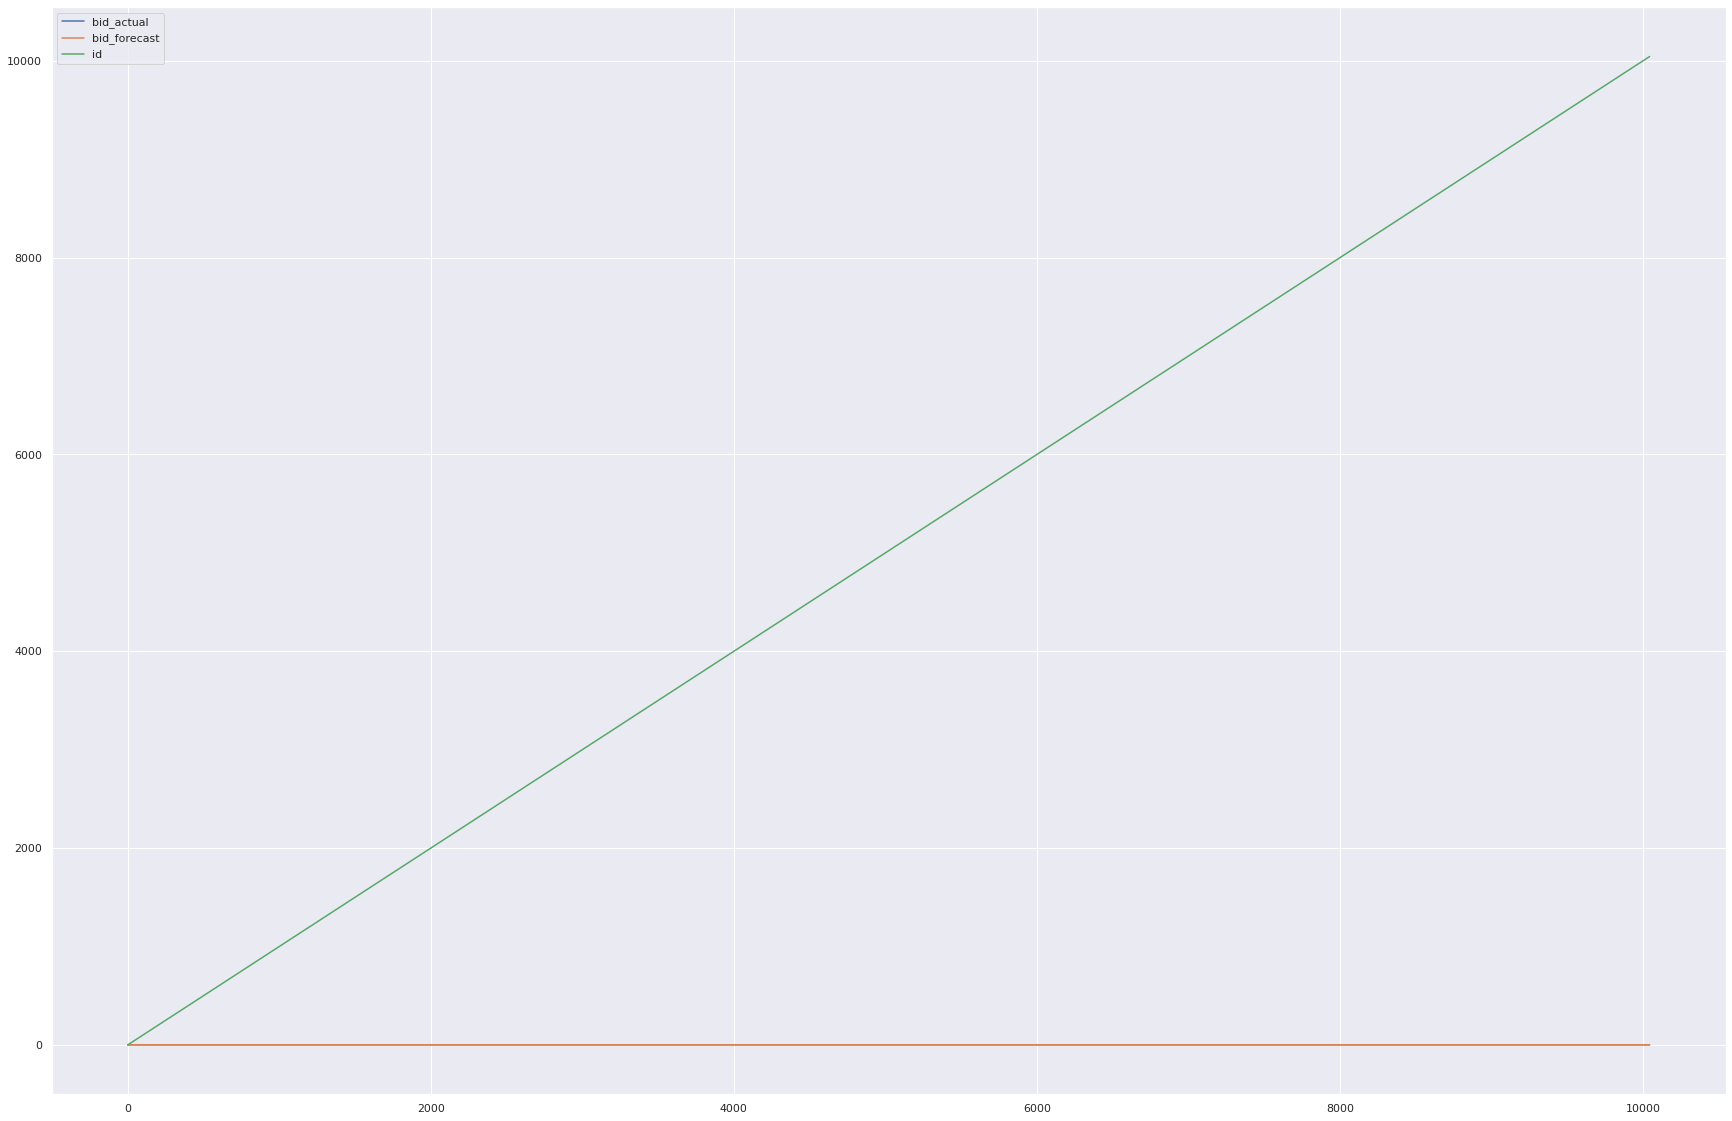

In [82]:
d_.plot()